In [31]:
import tensorflow as tf

# Define the training and validation directories
train_path = "/Users/sajallaha/Machine Learning/venv/New Plant Disease Dataset/train"
val_path = "/Users/sajallaha/Machine Learning/venv/New Plant Disease Dataset/valid"

# Load the training dataset BEFORE prefetching
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# Access class names BEFORE prefetching
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Apply data augmentation to training dataset
train_ds = train_ds_raw.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load validation set (no augmentation)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [32]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Unbatch to extract class indices
class_indices = []
for _, labels in train_ds_raw.unbatch():  
    class_idx = tf.argmax(labels).numpy()
    class_indices.append(class_idx)

# Compute class weights
class_weight_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_indices),
    y=class_indices
)

# Convert to dict
class_weight = dict(enumerate(class_weight_array))

print("Class Weights:", class_weight)

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Load EfficientNetB0 with pre-trained ImageNet weights
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False  # Set to True later for fine-tuning

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
     optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint("efficientnetb0_best.keras", monitor='val_accuracy', save_best_only=True)
]

#    Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weight 
)


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1595s 724ms/step - accuracy: 0.5580 - loss: 1.6305 - val_accuracy: 0.8511 - val_loss: 0.5585 - learning_rate: 1.0000e-04
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1391s 633ms/step - accuracy: 0.7831 - loss: 0.7153 - val_accuracy: 0.8978 - val_loss: 0.3666 - learning_rate: 1.0000e-04
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1379s 628ms/step - accuracy: 0.8263 - loss: 0.5607 - val_accuracy: 0.9094 - val_loss: 0.3064 - learning_rate: 1.0000e-04
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1475s 671ms/step - accuracy: 0.8481 - loss: 0.4799 - val_accuracy: 0.9223 - val_loss: 0.2615 - learning_rate: 1.0000e-04
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1586s 722ms/step - accuracy: 0.8613 - loss: 0.4355 - val_accuracy: 0.9274 - val_loss: 0.2397 - learning_rate: 1.0000e-04
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2277s 1s/step - accuracy: 0.8695 - loss: 0.4045 - val_accuracy: 0.9364 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 7/10
2197/2197 ━━━━

In [ ]:
model.save("efficientnetb0_new.keras")

In [ ]:
train_loss, train_acc = model.evaluate(train_ds_raw)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1269s 578ms/step - accuracy: 0.9452 - loss: 0.1750
Training Accuracy: 94.52%
Training Loss: 0.1750


In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 307s 555ms/step - accuracy: 0.9427 - loss: 0.1829
Validation Accuracy: 94.27%
Validation Loss: 0.1829


In [ ]:
import json

# Save history after training
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


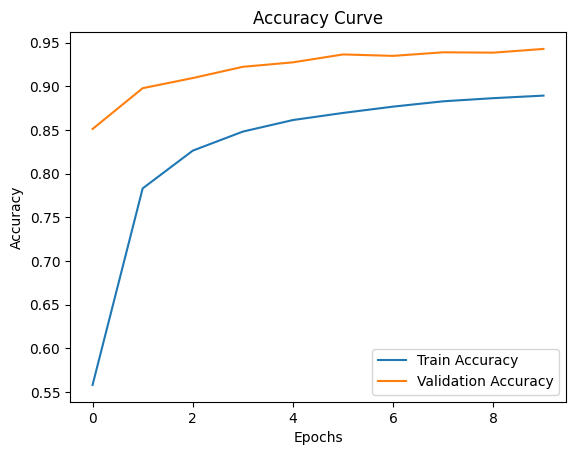

In [ ]:
# Load history later
with open('training_history.json', 'r') as f:
    loaded_history = json.load(f)

# Plotting (optional)
import matplotlib.pyplot as plt

plt.plot(loaded_history['accuracy'], label='Train Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

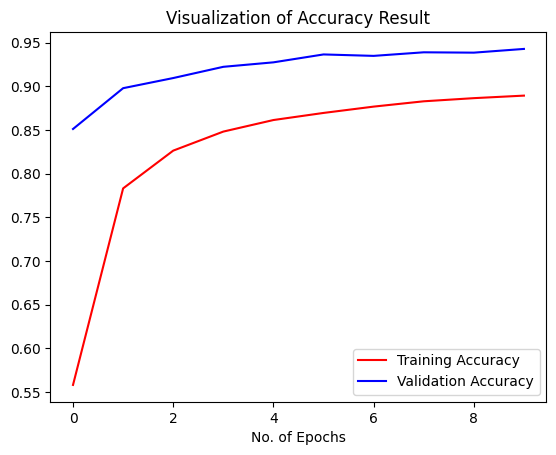

In [ ]:
epochs = [i for i in range(0,10)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [37]:
import json

# Load the training history from the JSON file
with open('training_history.json', 'r') as f:
    history = json.load(f)

# ✅ Now you can use `history` like a dictionary
print(history.keys())  # Shows available metrics like 'accuracy', 'loss', etc.

# Example: Print final training accuracy
final_acc = history['accuracy'][-1]
print(f"Final Training Accuracy: {final_acc * 100:.2f}%")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
Final Training Accuracy: 88.93%


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,062,679 (19.31 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 675,406 (2.58 MB)

In [ ]:
test_path = '/Users/sajallaha/Machine Learning/venv/New Plant Disease Dataset/valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False  # Important: no shuffle for confusion matrix
)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 17572 files belonging to 38 classes.


2026-02-12 10:19:52.877042: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


550/550 ━━━━━━━━━━━━━━━━━━━━ 277s 498ms/step


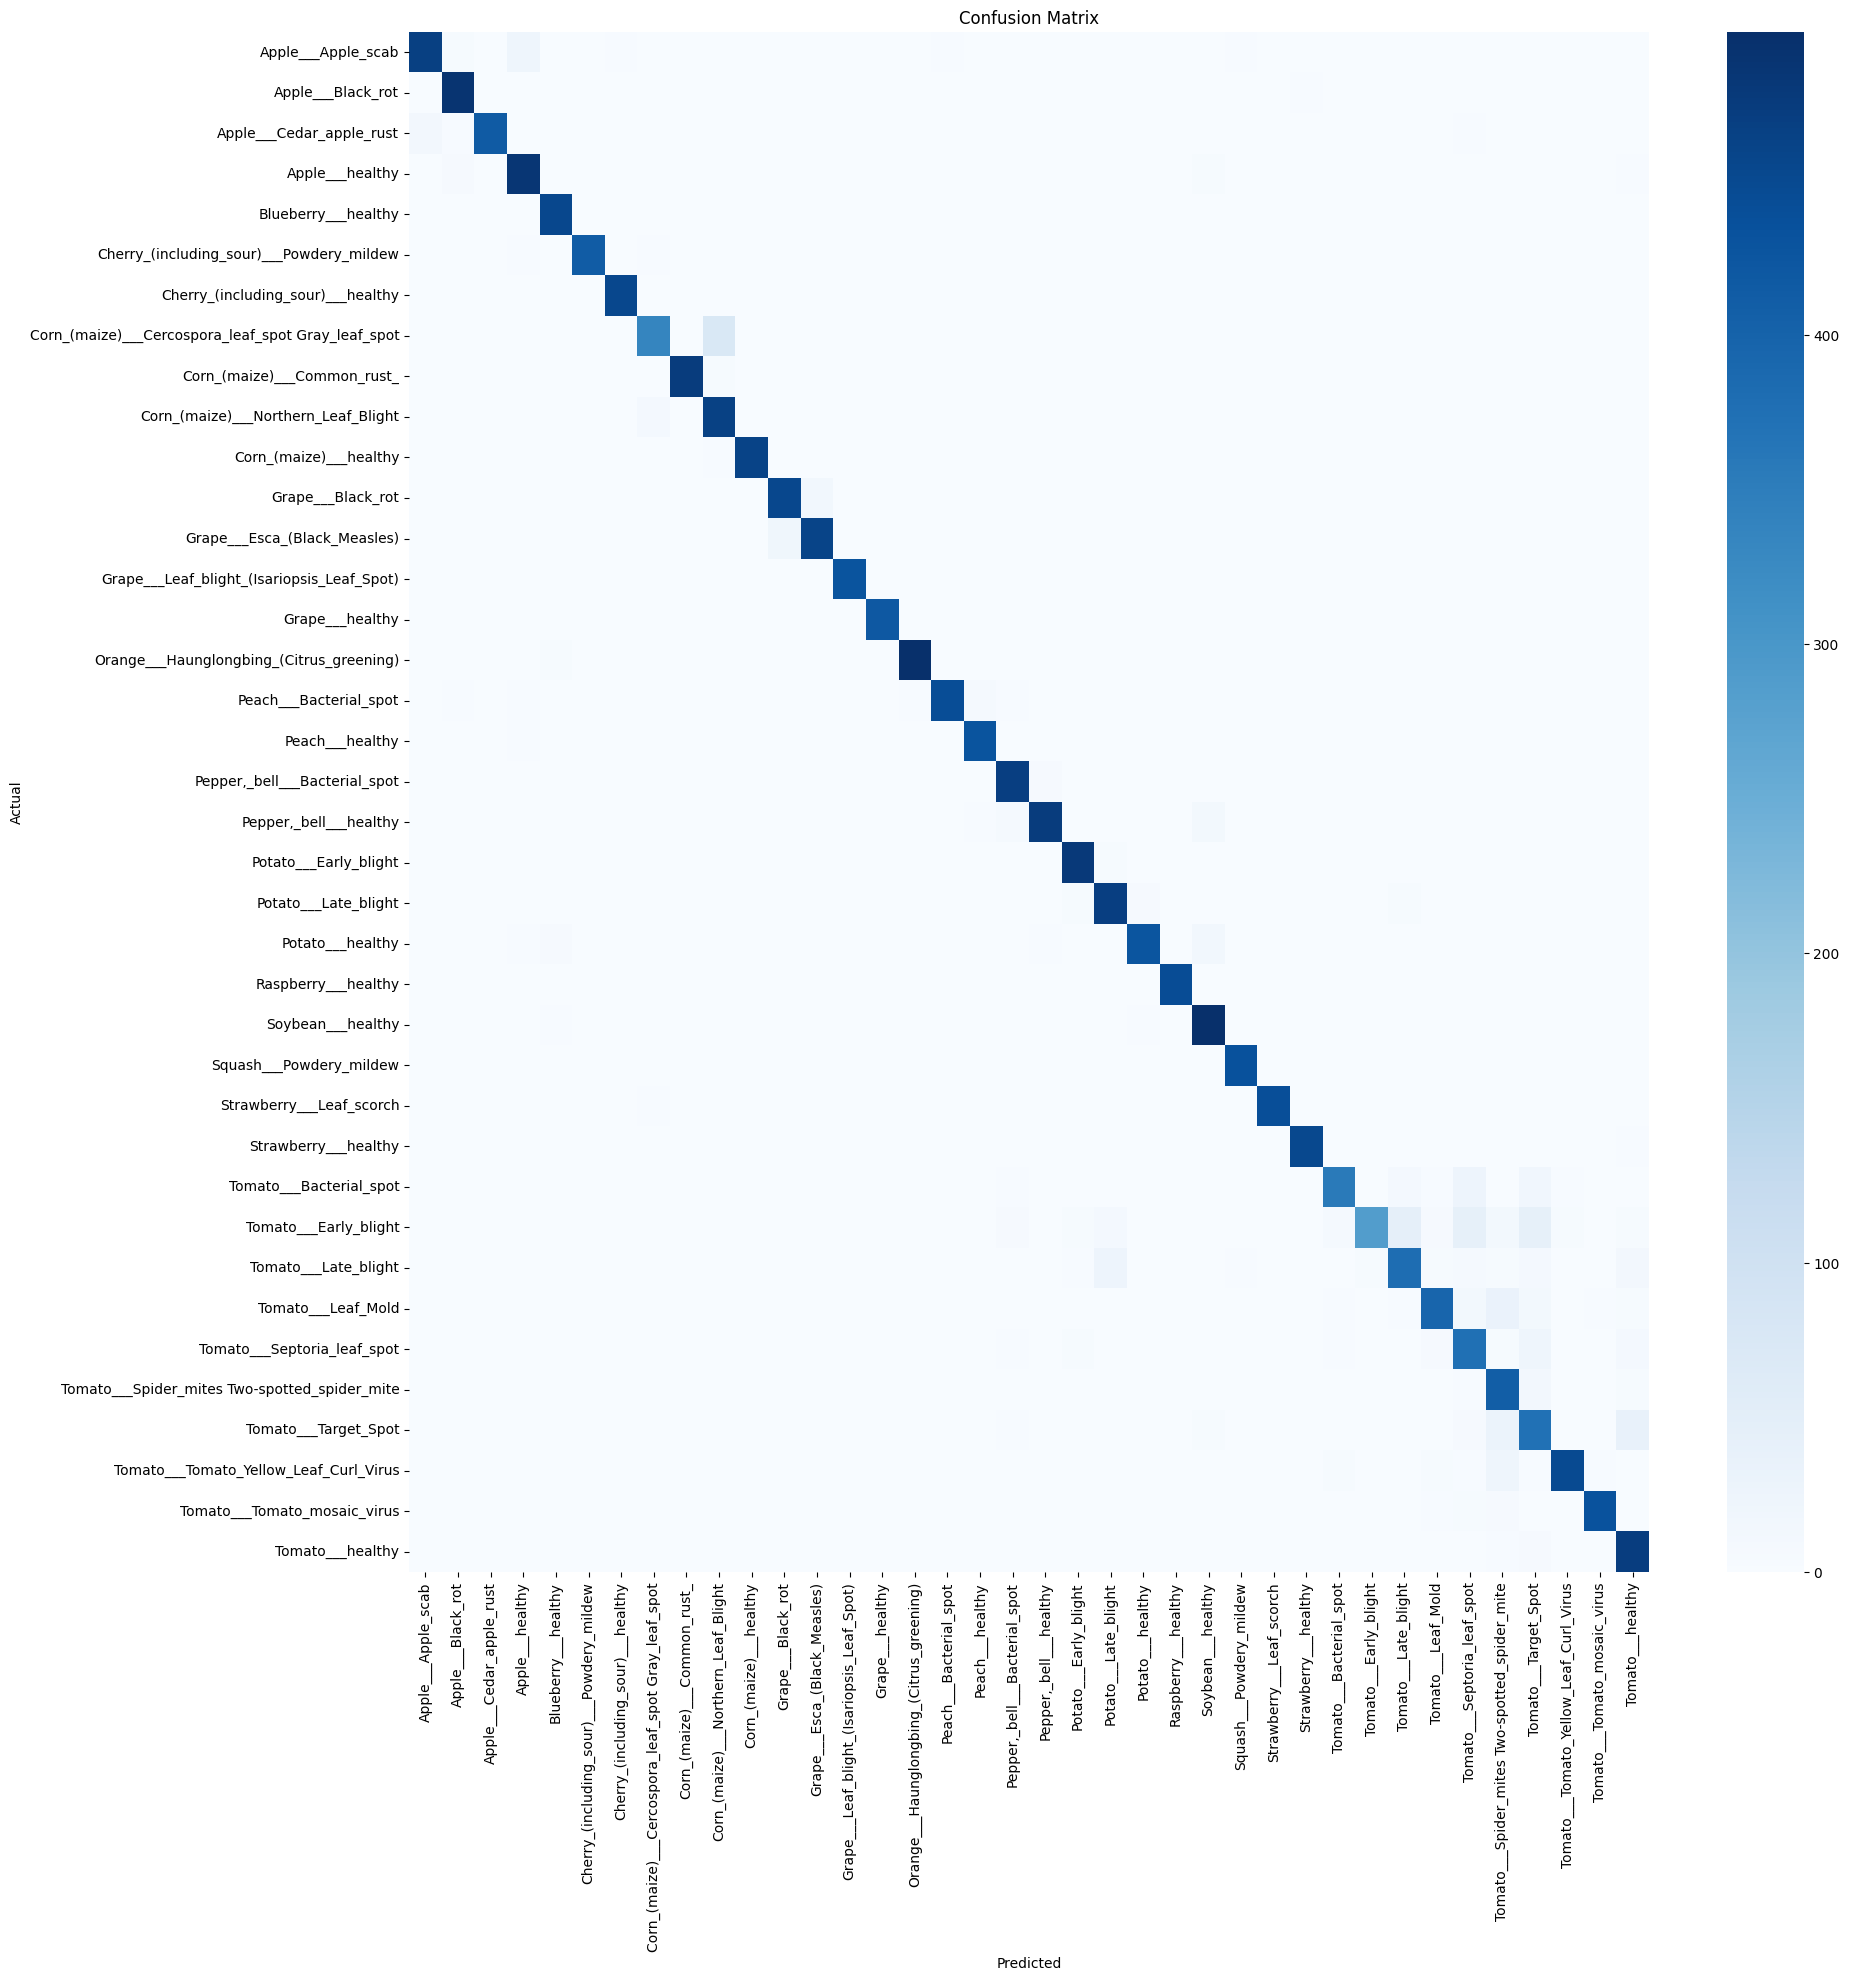

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.93      0.95       504
                                 Apple___Black_rot       0.96      0.99      0.98       497
                          Apple___Cedar_apple_rust       1.00      0.94      0.97       440
                                   Apple___healthy       0.94      0.97      0.95       502
                               Blueberry___healthy       0.96      1.00      0.98       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       421
                 Cherry_(including_sour)___healthy       0.98      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.82      0.88       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.85      0.97      0.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get ground truth labels
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true = np.argmax(y_true, axis=1)

# Get model predictions
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display with Seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Optional: print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [36]:
import tensorflow as tf  

# Create the dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/Users/sajallaha/Machine Learning/venv/New Plant Disease Dataset/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

# Retrieve class names
class_name = validation_set.class_names
print(class_name)

Found 17572 files belonging to 38 classes.
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Tw

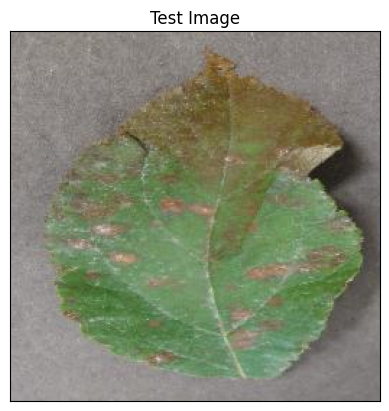

In [38]:
# Test Image Visualization
import cv2
import matplotlib.pyplot as plt  # Import matplotlib.pyplot

# Path to the image
image_path = '/Users/sajallaha/Machine Learning/venv/New Plant Disease Dataset/test/AppleCedarRust4.JPG'

# Reading an image in default mode
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load the image. Please check the file path.")
else:
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Displaying the image
    plt.imshow(img)
    plt.title('Test Image')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Load and preprocess image manually using Pillow
img = Image.open(image_path).resize((224, 224))

# Convert to array
input_arr = np.array(img)

input_arr = np.expand_dims(input_arr, axis=0)

# Optional: normalize (if your model expects it)
# input_arr = input_arr / 255.0

# Predict
predictions = model.predict(input_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
print(predictions)

[[3.2527992e-04 4.2036662e-04 9.9866784e-01 1.1719014e-06 2.8955004e-08
  9.6390628e-05 8.2345863e-08 3.5679041e-06 2.9562707e-07 3.6181680e-06
  6.7861516e-09 2.3537505e-05 6.4206297e-06 2.4697340e-07 9.4282723e-07
  2.1344188e-07 1.2185266e-04 6.1635124e-09 1.7099933e-06 5.3867701e-09
  2.0917378e-06 1.8497631e-05 1.5780975e-09 1.4431068e-08 6.7831882e-09
  1.4958422e-07 1.6746673e-06 1.7324849e-08 2.8774978e-04 2.8896388e-06
  2.6463661e-06 9.4135020e-09 1.0057400e-05 2.4785336e-08 3.7693366e-07
  6.3493584e-09 3.5856877e-09 2.3268763e-07]]


In [ ]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

2


In [34]:
import os

train_dir = "/Users/sajallaha/Machine Learning/venv/New Plant Disease Dataset/train"
class_names = sorted(os.listdir(train_dir))

# Save to class_names.txt
with open("class_names.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("✅ class_names.txt created.")

✅ class_names.txt created.


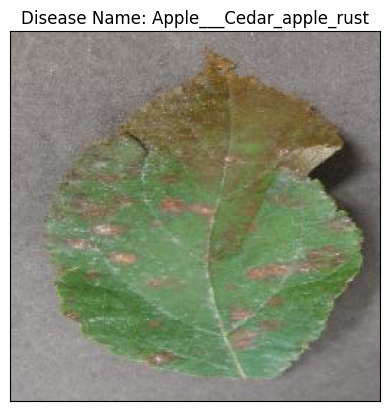

In [39]:
# Displaying the disease prediction
model_prediction = class_name[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()